Andy Nguyen, Michael Wolfe, Spencer Fogelman, & Joseph Caguioa

DS 7331.407

Thursday 6:30pm - 8:00pm

# Introduction

*Dataset Source: https://www.kaggle.com/rudymizrahi/airbnb-listings-in-major-us-cities-deloitte-ml*

This Kaggle dataset contains data on Airbnb listings for six major U.S. cities. The competition's original goal was to use available attributes to predict listing price. However, the dataset can be adjusted to predict other variables as well.

In this notebook, the dataset will be used for practicing classification/regression techniques.

### Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import csv
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Data Preparation Part 1

<i><b>10 pts.</b> Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.</i>

In [2]:
# Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/anguyen-07/DS7331-ML_Labs/master/data/airbnb_train.csv')

In [3]:
df['price'] = np.exp(df['log_price'])
df['grade'] = pd.cut(df.review_scores_rating, [0,60,70,80,90,101], right=False, labels = ['F', 'D', 'C', 'B', 'A'])

In [4]:
# Clean up datatypes and duplicates
df_ratings = df.dropna(subset=['review_scores_rating'])
floats = ['log_price','bathrooms','latitude','longitude','review_scores_rating']
df_ratings[floats] = df_ratings[floats].astype(np.float64)
ints = ['id','accommodates','number_of_reviews','bedrooms','beds']
df_ratings["host_response_rate"] = df_ratings["host_response_rate"].str.rstrip('%').astype(np.float64)/100
date_time = ['first_review','host_since','last_review']
df_ratings[date_time] = df_ratings[date_time].apply(pd.to_datetime)
booleans = ['host_has_profile_pic','host_identity_verified','instant_bookable']
df_ratings[booleans] = df_ratings[booleans].replace({'t':True,'f':False})
df_ratings[booleans] = df_ratings[booleans].astype(np.bool)
categorical = ['property_type','room_type','bed_type','cancellation_policy','city','neighbourhood','zipcode']
df_ratings[categorical] = df_ratings[categorical].astype('category')
df_ratings.drop_duplicates()
df_ratings.host_since[df_ratings.host_since.isna()] = df_ratings.first_review[df_ratings.host_since.isna()]

C:\Users\k\Anaconda3\envs\DS7331_MachineLearningI\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\k\Anaconda3\envs\DS7331_MachineLearningI\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\k\Anaconda3\envs\DS7331_MachineLearningI\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pa

In [5]:
# Impute missing values
df_imputed = df_ratings
df_imputed["bathrooms"] = df_imputed["bathrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bathrooms"].apply(lambda x : x.fillna(x.median())))
df_imputed["bedrooms"] = df_imputed["bedrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bedrooms"].apply(lambda x : x.fillna(x.median())))
df_imputed["beds"] = df_imputed["beds"].fillna(df_imputed.groupby(["property_type","accommodates"])["beds"].apply(lambda x : x.fillna(x.median())))
df_imputed["host_response_rate"] = df_imputed["host_response_rate"].fillna(df_imputed.groupby(["number_of_reviews"])["host_response_rate"].apply(lambda x : x.fillna(x.mean())))
# Impute Missing Value of for 100% Host Response Rate for Row 48194 - Private Room in Apartment
df_imputed["host_response_rate"][df_imputed["host_response_rate"].isna()] = 1.0
df_imputed[ints] = df_imputed[ints].astype(np.int64)

C:\Users\k\Anaconda3\envs\DS7331_MachineLearningI\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\k\Anaconda3\envs\DS7331_MachineLearningI\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\k\Anaconda3\envs\DS7331_MachineLearningI\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [6]:
import re
#Create a new cleaned amenities column where all amenities are in list form
df_imputed['amenities_new'] = df_imputed.apply(lambda row: re.sub(r'[{}""]', '', row['amenities']), axis=1)
df_imputed['amenities_new'] = df_imputed.apply(lambda row: row['amenities_new'].lower().split(','), axis=1)
df_imputed = df_imputed.reset_index()
df_imputed['length_amenities'] = df_imputed.apply(lambda row: len(row['amenities_new']), axis=1)

# Create separate columns based on amenities
df_imputed['internet'] = df_imputed.apply(lambda row: 'internet' in row.amenities.lower(), axis=1)
df_imputed['TV'] = df_imputed.apply(lambda row: 'tv' in row.amenities.lower(), axis=1)
df_imputed['air_conditioning'] = df_imputed.apply(lambda row: 'air conditioning' in row.amenities.lower(), axis=1)
df_imputed['kitchen'] = df_imputed.apply(lambda row: 'kitchen' in row.amenities.lower(), axis=1)
df_imputed['pool'] = df_imputed.apply(lambda row: 'pool' in row.amenities.lower(), axis=1)
df_imputed['parking'] = df_imputed.apply(lambda row: 'parking' in row.amenities.lower(), axis=1)

# Get information from description based on length in characters
df_imputed['description_length'] = df_imputed['description'].apply(len)

# Create the target variable superuser
df_imputed['superuser'] = False
df_imputed.loc[df.review_scores_rating >=96, 'superuser'] = True

# Create altnerative target variable grade_grouped
new_grades = {
    'A':'A',
    'B':'<A',
    'C':'<A',
    'D':'<A',
    'F':'<A'
}
df_imputed['grade_grouped'] = df_imputed['grade'].map(new_grades)

C:\Users\k\Anaconda3\envs\DS7331_MachineLearningI\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\k\Anaconda3\envs\DS7331_MachineLearningI\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [8]:
import datetime
date_published = datetime.datetime(2018,3,14)
df_imputed['host_since'] = pd.to_datetime(df_imputed['host_since'])
df_imputed['host_since_days'] = df_imputed.apply(lambda row: (date_published - row['host_since']).days, axis=1)

Removed columns that are not meaningful in a modeling context (i.e., index,id), redundant with newly engineered features (i.e., amenities, description), or are likenly not useful in predicting the target variable grade_grouped.

In [14]:
# delete useless columns
df_logistic = df_imputed.drop(['index','id','price','amenities','description','zipcode','description_length',
                               'latitude','longitude','name','neighbourhood','review_scores_rating','thumbnail_url',
                               'zipcode'], axis=1)

# delete other redundant variables
del df_logistic['amenities_new']
del df_logistic['host_since']
del df_logistic['grade']
del df_logistic['first_review']
del df_logistic['last_review']

# Remove factor with unncessarily large number of levels
df_logistic.drop(['property_type'], axis=1, inplace=True)

One-Hot Encode Categorical Variables with multiple levels.

In [15]:
categorical_vars = ['room_type','bed_type','cancellation_policy','city']

# Create Dummy Variables
multiCategorical_vars = ['city','cancellation_policy','bed_type','room_type']

dummy_df = pd.get_dummies(df_logistic[multiCategorical_vars], drop_first = True)
df_final = pd.concat([df_logistic, dummy_df], axis=1)

# Delete non-dummy categorical variables
for x in categorical_vars:
    if x in df_final:
        del df_final[x]

df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57389 entries, 0 to 57388
Data columns (total 36 columns):
log_price                              57389 non-null float64
accommodates                           57389 non-null int64
bathrooms                              57389 non-null float64
cleaning_fee                           57389 non-null bool
host_has_profile_pic                   57389 non-null bool
host_identity_verified                 57389 non-null bool
host_response_rate                     57389 non-null float64
instant_bookable                       57389 non-null bool
number_of_reviews                      57389 non-null int64
bedrooms                               57389 non-null int64
beds                                   57389 non-null int64
length_amenities                       57389 non-null int64
internet                               57389 non-null bool
TV                                     57389 non-null bool
air_conditioning                       57389 non-nu

# Data Preparation Part 2

<i><b>5 pts.</b> Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).</i>

In [16]:
df_final.describe()

,log_price,accommodates,bathrooms,host_response_rate,number_of_reviews,bedrooms,beds,length_amenities,host_since_days,city_Chicago,...,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,room_type_Private room,room_type_Shared room
count,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,...,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000,57389.000000
mean,4.749232,3.218247,1.225967,0.952633,26.957326,1.260904,1.737546,18.357943,1373.129380,0.055899,...,0.287355,0.484884,0.001446,0.000174,0.002771,0.010560,0.008608,0.972068,0.399536,0.025144
std,0.668700,2.144154,0.561473,0.122000,41.043449,0.841280,1.265311,6.907464,662.667741,0.229729,...,0.452532,0.499776,0.038003,0.013199,0.052564,0.102216,0.092380,0.164780,0.489807,0.156564
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,167.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.304065,2.000000,1.000000,0.940000,3.000000,1.000000,1.000000,14.000000,851.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,4.700480,2.000000,1.000000,1.000000,11.000000,1.000000,1.000000,18.000000,1312.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,5.164786,4.000000,1.000000,1.000000,33.000000,1.000000,2.000000,22.000000,1841.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,7.600402,16.000000,8.000000,1.000000,605.000000,10.000000,18.000000,77.000000,3663.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**For the purposes of regression**, we have created a number of new variables. First, we created log_price, a natural log of the price to amend distribution of the original price variable.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000260BDEC3108>]],
      dtype=object)

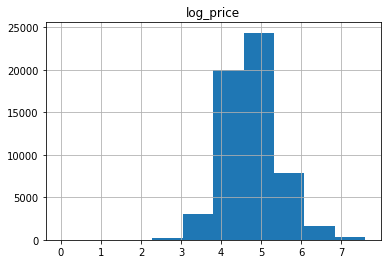

In [17]:
# The original price variable was removed from the final dataset since it is redundant with log_price
df_final.hist(column='log_price')

As pictured above, the log price has a much more normal distribution. Another attribute we created is the host_since_days, a calculation of how many days a host has been active, defined as the days they became a host subtracted from the current date.

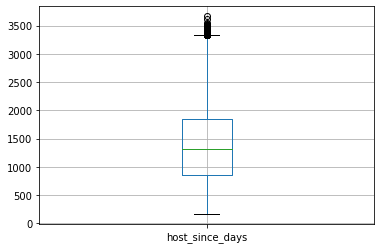

In [10]:
df_imputed.boxplot(column='host_since_days')

This appears to be right-skewed, with a number of outliers. Some of the hosts look to have been active for a very long time. Another "time-based" variable we created is the length_amenities variable. Some listings have new amenities added, and we created length amenities to create a metric similar to host_since_days.

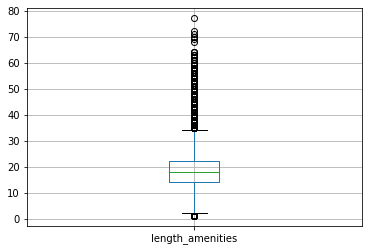

In [11]:
df_imputed.boxplot(column='length_amenities')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C9F5C27688>]],
      dtype=object)

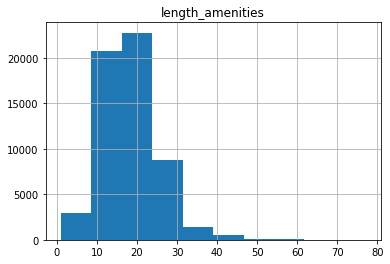

In [12]:
df_imputed.hist(column='length_amenities')

Very heavy right skew. There are a number of amenities that are very new, which pushes the distribution low, but the large concentration of smaller values pushes the handful of older amenities into outlier territory.

**For the purpose of classification**, we have created a target variable (superuser/grade_grouped) to identify potential hosts that may be targeted for AirBnb's superhost program.

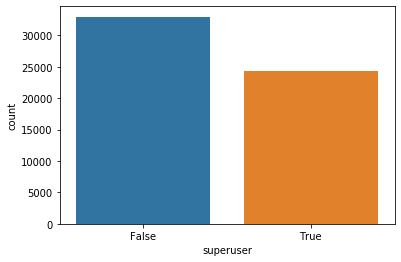

In [21]:
sns.countplot(data=df_final, x = 'superuser')
# We will remove one of these variables from the final dataset,
# but I included both for now since we haven't reached a final decision yet

For the superuser target variable, there is a slight imbalance of classes with 24,402 (42.5%) instances in the dataset recieving a rating review score of 96% or higher. On the other hand, 32,987 (57.5%) instances recieved a rating review score lower than 96%. 

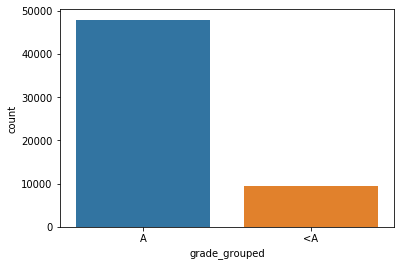

In [19]:
sns.countplot(data=df_final, x = 'grade_grouped')

For the grade_grouped target variable, there is a heavy imbalance of classes with 47,897 (83.5%) instances in the dataset reciving a rating review score of 90% or higher. On the other hand, only 9,492 instances recieved a rating review score lower than 90%. Although our EDA, shows a clear separation between the classes of A and <A compared to the 96% cutoff with the superuser variable. With this heavy imbalance, we will attempt to build our classification models using prior probabilities to optimize model performance and prediction accuracy.

# Modeling and Evaluation 1

<i><b>10 pts.</b> Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.</i>

Given the task of classification to identify potential AirBnb hosts that should be targeted for the Superhost program, we will prioritize high precision for the grade_grouped target variable since there is a large majority for the class with an A grade for their ratings review score. With an abundance of instances for this class, we would like to minimize the false positives because we want to correctly determine which AirBnb hosts are ideal for the Superhost program. We also may want to evaluate our model with the F-measure to minimize the false negative predictions because we do not want to miss out on superb hosts that would benefit from the Superhost program. Additionally, the heavy imbalanced class distribution 

# Modeling and Evaluation 2

<i><b>10 pts.</b> Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.</i>

# Modeling and Evaluation 3

<i><b>20 pts.</b> Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!</i>

# Modeling and Evaluation 4

<i><b>10 pts.</b> Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.</i>

# Modeling and Evaluation 5

<i><b>10 pts.</b> Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.</i>

# Modeling and Evaluation 6

<i><b>10 pts.</b> Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.</i>

# Deployment

<i><b>5 pts.</b> How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?</i>

# Exceptional Work

<i><b>10 pts.</b> You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?</i>